# パッケージインストール

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers accelerate
!pip install -q qwen-vl-utils[decord]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 156.8 MB/s eta 0:00:00


# サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/Qwen3-VL-Colaboratory-Sample/refs/heads/main/sample.jpg -O sample.jpg

--2025-11-12 07:42:24--  https://user0514.cdnw.net/shared/img/thumb/fujikokyoto02_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.105.216.58
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.105.216.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94332 (92K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  92.12K   508KB/s    in 0.2s    

2025-11-12 07:42:24 (508 KB/s) - ‘sample.jpg’ saved [94332/94332]



# モデル読み込み

In [ ]:
# モデル選択
model_path = "Qwen/Qwen3-VL-4B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-4B-Thinking"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-8B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-8B-Thinking"  # T4 GPU

In [ ]:
from transformers import Qwen3VLForConditionalGeneration, AutoTokenizer, AutoProcessor

model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

# プロンプト生成

In [ ]:
from qwen_vl_utils import process_vision_info

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "sample.jpg"},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 推論

In [ ]:
%%time

generated_ids = model.generate(**inputs, max_new_tokens=4096)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

CPU times: user 34.3 s, sys: 548 ms, total: 34.9 s
Wall time: 35.9 s


# 結果確認

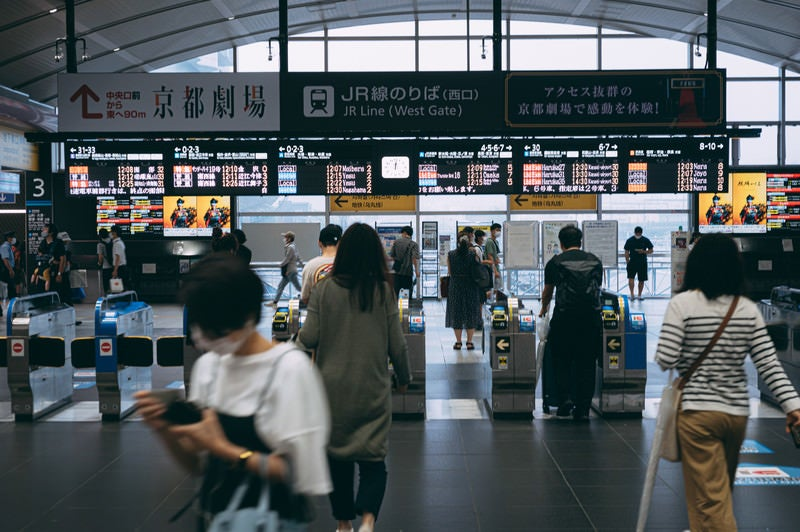

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
cv2_imshow(image)

In [ ]:
import textwrap

print(textwrap.fill(output_text[0], width=50))

この画像は、日本の駅（おそらく京都駅）の改札エリアを捉えたものです。明るい天井と大きな窓から差し込む
自然光が、広々とした空間を照らしています。  中央には大きな電子掲示板があり、列車の到着・出発情報を
表示しています。掲示板の上部には「京都劇場」への案内と「JR線のりば（西口）」の案内が見えます。また
、「アクセス抜群の京都劇場で感動を体験！」という宣伝文も掲示されています。  改札口の前には多くの人
が行き交っており、その中にはマスクを着用している人もいます。人々は各々の目的地に向かって移動しており
、日常の通勤や観光の様子が感じられます。  前景には、スマホを操作している女性や、ストライプのシャツ
を着た女性など、多様な姿が写っています。背景には駅の構内と、さらに奥の駅の様子が見え、活気ある駅の雰
囲気が伝わってきます。  全体的に、現代の都市駅の賑わいと、観光地である京都劇場へのアクセスの便利さ
を強調した、実用的で活気あるシーンです。


# プロンプト生成

In [ ]:
from qwen_vl_utils import process_vision_info

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "sample.jpg"},
            {"type": "text", "text": "物体検出でマスクをかけた人物を検出してください。バウンディングボックス座標とラベル名はJSON形式で出力してください。JSONのラベル名は英語で出力してください。"},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 推論

In [ ]:
%%time

generated_ids = model.generate(**inputs, max_new_tokens=16384)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

CPU times: user 30.4 s, sys: 468 ms, total: 30.8 s
Wall time: 30.8 s


# 結果確認

In [ ]:
import textwrap

print(output_text[0])

```json
[
	{"bbox_2d": [164, 487, 417, 1000], "label": "person wearing mask"},
	{"bbox_2d": [555, 438, 607, 659], "label": "person wearing mask"},
	{"bbox_2d": [668, 421, 757, 786], "label": "person wearing mask"},
	{"bbox_2d": [117, 421, 150, 567], "label": "person wearing mask"},
	{"bbox_2d": [42, 421, 87, 569], "label": "person wearing mask"},
	{"bbox_2d": [597, 421, 630, 553], "label": "person wearing mask"},
	{"bbox_2d": [777, 421, 814, 569], "label": "person wearing mask"}
]
```


In [ ]:
import copy
import json
import re
import cv2
import random


def draw_bboxes_from_json_str(json_str: str, image):
    # ```json ～ ``` の中を抽出
    match = re.search(r"```json(.*?)```", json_str, flags=re.DOTALL)
    if not match:
        raise ValueError("JSON が ```json ... ``` の形式で見つかりません")

    json_body = match.group(1)

    # JSON をパース
    try:
        data = json.loads(json_body)
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON パースエラー: {e}")

    debug_image = copy.deepcopy(image)

    # ---- ラベルごとの色定義 ----
    # 必要に応じて追加
    label_colors = {
        "person":     (0, 255, 0),     # green
        "car":        (0, 0, 255),     # red
    }

    # 未登録ラベルの色を保持（毎回ランダム生成し、同じラベルは同じ色を使う）
    random_color_cache = {}

    def get_color(label: str):
        if label in label_colors:
            return label_colors[label]

        if label not in random_color_cache:
            random_color_cache[label] = (
                random.randint(50, 255),
                random.randint(50, 255),
                random.randint(50, 255)
            )
        return random_color_cache[label]

    # 描画
    for obj in data:
        bbox = obj["bbox_2d"]
        label = obj["label"]

        height, width = image.shape[:2]

        # x1, y1, x2, y2   (0-1000 正規化 → pixel)
        x1 = int(bbox[0] / 1000 * width)
        y1 = int(bbox[1] / 1000 * height)
        x2 = int(bbox[2] / 1000 * width)
        y2 = int(bbox[3] / 1000 * height)

        # ラベルごとの色
        color = get_color(label)

        # bbox
        cv2.rectangle(debug_image, (x1, y1), (x2, y2), color, 2)

        # label
        cv2.putText(
            debug_image,
            label,
            (x1, y1 - 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.75,
            color,
            2
        )

    return debug_image

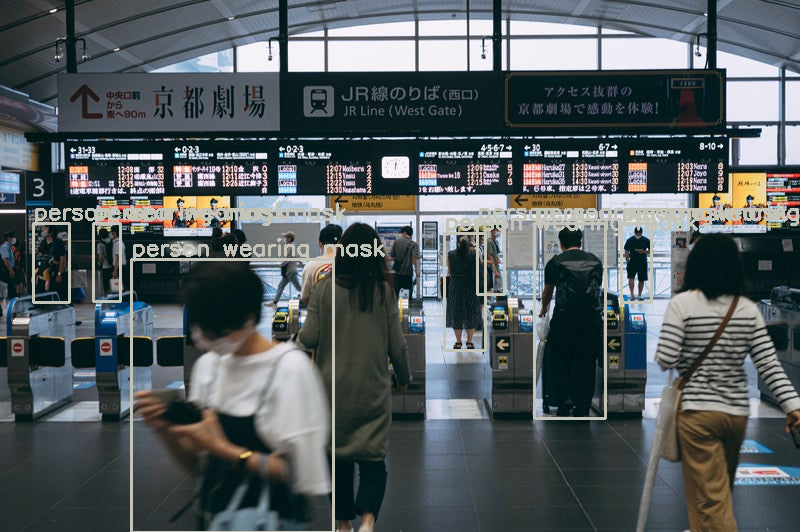

In [ ]:
debug_image = draw_bboxes_from_json_str(output_text[0], image)

cv2_imshow(debug_image)